In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz

| Index | Ear Shape | Face Shape | Whiskers | Cat |
|:-----:|:---------:|:----------:|:--------:|:---:|
|   0   |   Pointy  |   Round    | Present  |  1  |
|   1   |   Floppy  | Not Round  | Present  |  1  |
|   2   |   Floppy  |   Round    | Absent   |  0  |
|   3   |   Pointy  | Not Round  | Present  |  0  |
|   4   |   Pointy  |   Round    | Present  |  1  |
|   5   |   Pointy  |   Round    | Absent   |  1  |
|   6   |   Floppy  | Not Round  | Absent   |  0  |
|   7   |   Pointy  |   Round    | Absent   |  1  |
|   8   |   Floppy  |   Round    | Absent   |  0  |
|   9   |   Floppy  |   Round    | Absent   |  0  |


We will use **one-hot encoding** to encode the categorical features. They will be as follows:

- Ear Shape: Pointy = 1, Floppy = 0
- Face Shape: Round = 1, Not Round = 0
- Whiskers: Present = 1, Absent = 0

Therefore, we have two sets:

- `X_train`: for each example, contains 3 features:
            - Ear Shape (1 if pointy, 0 otherwise)
            - Face Shape (1 if round, 0 otherwise)
            - Whiskers (1 if present, 0 otherwise)
            
- `y_train`: whether the animal is a cat
            - 1 if the animal is a cat
            - 0 otherwise

In [2]:
X_train = np.array([
    [1, 1, 1],
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 1],
    [1, 1, 1],
    [1, 1, 0],
    [0, 0, 0],
    [1, 1, 0],
    [0, 1, 0],
    [0, 1, 0]
])

Y_train = np.array([1, 1, 0, 0, 1, 1, 0, 1, 0, 0])

# 1. Caculate Information Gain as a measure of Impurity

In [3]:
def entropy(p):
    if p == 0 or p == 1:
        return 0
    else:
        return - p * np.log2(p) - (1 - p) * np.log2(1 - p)

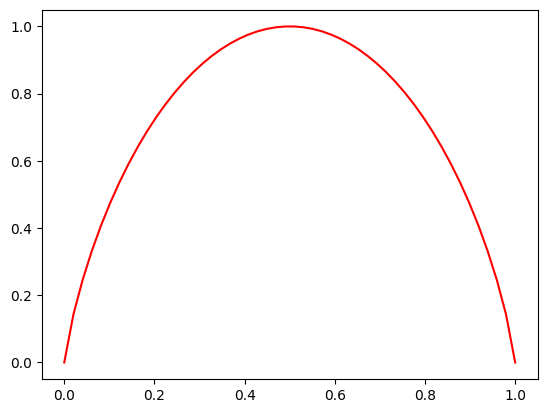

In [4]:
p = np.linspace(1e-15, 1, 50)
entropy_p = np.array([entropy(i) for i in p]) 
plt.plot(p, entropy_p, 'r')

In [5]:
def split_indices(X, feature_index):
    """ Given a dataset and an index feature, return two lists for the two split nodes, 
    the left node has the animals that have that feature = 1 and the right node those that have the feature = 0
    X is an array containing all samples, each sample has 3 features
        feature_index = 0 => ear shape
        feature_index = 1 => face shape
        feature_index = 2 => whiskers
    """
    left_indices = []
    right_indices = []
    for sample_idx, sample_features in enumerate(X):
        if sample_features[feature_index] == 1:
            left_indices.append(sample_idx)
        else:
            right_indices.append(sample_idx)
            
    return left_indices, right_indices

In [6]:
def split_indices_if_numerical(X, feature_index, split_value):
    left_indices = []
    right_indices = []
    for sample_idx, sample_features in enumerate(X):
        if sample_features[feature_index] <= split_value:
            left_indices.append(sample_idx)
        else:
            right_indices.append(sample_idx)
    return left_indices, right_indices

In [7]:
def weighted_sum_of_entropy(X, Y, left_indices, right_indices):
    """
    This function takes the split dataset, and the indices we chose to split, and returns the weighted sum of entropy.
    """
    w_left = len(left_indices) / len(X)
    w_right = len(right_indices) / len(X)

    cats_in_left = sum(Y[left_indices])
    animals_in_left = len(left_indices)
    p_left = 0  # UnboundLocalError: cannot access local variable 'p_right' where it is not associated with a value
    if animals_in_left > 0:
        p_left = cats_in_left / animals_in_left

    cats_in_right = sum(Y[right_indices])
    animals_in_right = len(right_indices)
    p_right = 0
    if animals_in_right > 0:
        p_right = cats_in_right / animals_in_right
    
    weighted_sum = w_left * entropy(p_left) + w_right * entropy(p_right)
    return weighted_sum

In [8]:
def information_gain(X, Y, left_indices, right_indices):
    """
    Here, X has the elements in the node and y is their respective classes
    """
    cats_before_split = sum(Y)
    animals_before_split = len(Y)
    p_before_split = cats_before_split / animals_before_split
    
    entropy_before_split = entropy(p_before_split)
    entropy_after_split = weighted_sum_of_entropy(X, Y, left_indices, right_indices)

    return entropy_before_split - entropy_after_split

# 2. Find the Feature of Root Node

In [9]:
for feature_index, feature_name in enumerate(['Ear Shape', 'Face Shape', 'Whiskers']):
    left_indices, right_indices = split_indices(X_train, feature_index)
    info_gain = information_gain(X_train, Y_train, left_indices, right_indices)
    
    print(f"Feature: {feature_name:<10}, Information Gain if we split the root node using This Feature: {info_gain:.2f}")

Feature: Ear Shape , Information Gain if we split the root node using This Feature: 0.28
Feature: Face Shape, Information Gain if we split the root node using This Feature: 0.03
Feature: Whiskers  , Information Gain if we split the root node using This Feature: 0.12


##### ==> Pick Feature for the Root Node: Ear Shape

In [10]:
left_indices, right_indices = split_indices(X_train, 0)
left_indices, right_indices

([0, 3, 4, 5, 7], [1, 2, 6, 8, 9])

In [11]:
def find_best_split(X, Y):
    best_feature = -1
    best_info_gain = -float('inf')
    best_split_value_if_numerical = None
    best_split_indices = None

    for feature_index in range(X.shape[1]):
        unique_values = np.unique(X[:, feature_index])
        
        if set(unique_values).issubset({0, 1}):
            left_indices, right_indices = split_indices(X, feature_index)
            info_gain = information_gain(X, Y, left_indices, right_indices)
            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_feature = feature_index
                best_split_indices = (left_indices, right_indices)

        else:
            sorted_indices = np.argsort(X[:, feature_index])
            sorted_X = X[sorted_indices]
            sorted_Y = Y[sorted_indices]
            for idx in range(0, len(sorted_X)-1):
                if sorted_X[idx, feature_index] != sorted_X[idx+1, feature_index]:
                    split_value = (sorted_X[idx, feature_index] + sorted_X[idx+1, feature_index]) / 2
                    left_indices, right_indices = split_indices_if_numerical(X, feature_index, split_value)
                    info_gain = information_gain(X, Y, left_indices, right_indices)
    
                    if info_gain > best_info_gain:
                        best_info_gain = info_gain
                        best_feature = feature_index
                        best_split_value_if_numerical = split_value
                        best_split_indices = (left_indices, right_indices)
            
    if best_info_gain == 0:
        print('Tree has already been optimized')
        return None

    return best_feature, best_info_gain, best_split_indices, best_split_value_if_numerical

In [12]:
def samples_after_split(X, Y):
    _, _, best_split_indices, _ = find_best_split(X, Y)
    left_indices = best_split_indices[0]
    right_indices = best_split_indices[1]
    
    X_left = X[left_indices]
    X_right = X[right_indices]
    Y_left = Y[left_indices]
    Y_right = Y[right_indices]

    return X_left, Y_left, X_right, Y_right

In [13]:
best_feature, best_info_gain, best_split_indices, _ = find_best_split(X_train, Y_train)
best_feature, best_info_gain, best_split_indices

(0, 0.2780719051126377, ([0, 3, 4, 5, 7], [1, 2, 6, 8, 9]))

In [14]:
X_left, Y_left, X_right, Y_right = samples_after_split(X_train, Y_train)
Y_left, Y_right

(array([1, 0, 1, 1, 1]), array([1, 0, 0, 0, 0]))

# 3. Build Next Nodes

***Continue to split the left***

In [15]:
find_best_split(X_left, Y_left)

(1, 0.7219280948873623, ([0, 2, 3, 4], [1]), None)

In [16]:
X_left_left, Y_left_left, X_left_right, Y_left_right = samples_after_split(X_left, Y_left)
Y_left_left, Y_left_right

(array([1, 1, 1, 1]), array([0]))

***Continue to split the right***

In [17]:
find_best_split(X_right, Y_right)

(2, 0.7219280948873623, ([0], [1, 2, 3, 4]), None)

In [18]:
X_right_left, Y_right_left, X_right_right, Y_right_right = samples_after_split(X_right, Y_right)
Y_right_left, Y_right_right

(array([1]), array([0, 0, 0, 0]))

---

***Continue to split the left of the left***

In [19]:
find_best_split(X_left_left, Y_left_left)

Tree has already been optimized


***Continue to split the right of the left***

In [20]:
find_best_split(X_left_right, Y_left_right)

Tree has already been optimized


***Continue to split the left of the right***

In [21]:
find_best_split(X_right_left, Y_right_left)

Tree has already been optimized


***Continue to split the right of the right***

In [22]:
find_best_split(X_right_right, Y_right_right)

Tree has already been optimized


# 4. Using sklearn

In [23]:
dtc = DecisionTreeClassifier(criterion='entropy')
dtc.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy')

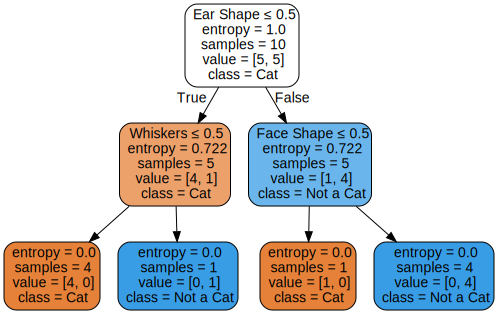

<Figure size 100x100 with 0 Axes>

In [24]:
import graphviz
dot = export_graphviz(dtc, feature_names=['Ear Shape', 'Face Shape', 'Whiskers'], class_names=['Cat', 'Not a Cat'], 
                      impurity=True, filled=True, rounded=True, special_characters=True)

plt.figure(figsize=(1,1))
graph = graphviz.Source(dot)
graph

### In case there is a column containing numerical value

In [25]:
X = np.array([[2.5, 1], [1.5, 2], [3.5, 2], [1.5, 1], [3.5, 1]])
Y = np.array([0, 0, 1, 1, 0])

In [26]:
find_best_split(X, Y)

(0, 0.01997309402197489, ([1, 3], [0, 2, 4]), 2.0)

In [27]:
X_left, Y_left, X_right, Y_right = samples_after_split(X, Y)
Y_left, Y_right

(array([0, 1]), array([0, 1, 0]))

In [28]:
find_best_split(X_left, Y_left)

(1, 1.0, ([1], [0]), 1.5)

In [29]:
X_left_left, Y_left_left, X_left_right, Y_left_right = samples_after_split(X_left, Y_left)
Y_left_left, Y_left_right

(array([1]), array([0]))

In [30]:
find_best_split(X_right, Y_right)

(1, 0.9182958340544896, ([0, 2], [1]), 1.5)

In [31]:
X_right_left, Y_right_left, X_right_right, Y_right_right = samples_after_split(X_right, Y_right)
Y_right_left, Y_right_right

(array([0, 0]), array([1]))

In [32]:
dtc_if_numerical = DecisionTreeClassifier(criterion='entropy', random_state=42)
dtc_if_numerical.fit(X, Y)

DecisionTreeClassifier(criterion='entropy', random_state=42)

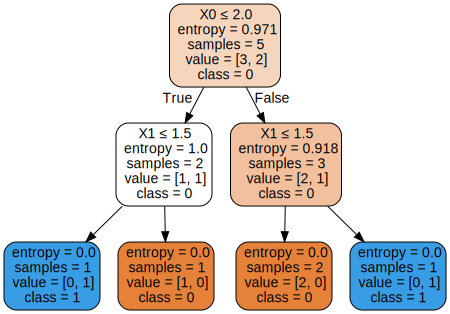

<Figure size 100x100 with 0 Axes>

In [33]:
dot = export_graphviz(dtc_if_numerical, feature_names=['X0', 'X1'], class_names=['0', '1'], 
                      impurity=True, filled=True, rounded=True, special_characters=True)

plt.figure(figsize=(1,1))
graph = graphviz.Source(dot)
graph